In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings

warnings.filterwarnings("ignore")

In [111]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_money = pd.read_csv('train_final.csv')

### 오류 제거
- 1번 오류 : 상위 4개만 제거
- 2번, 3번 오류 : 전부 제거

In [112]:

error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data :
    train = train[train['단지코드'] != error]
    

# train = train[train.단지코드 != 'C1804']
# train = train[train.단지코드 != 'C2405']
# train = train[train.단지코드 != 'C1740']
# train = train[train.단지코드 != 'C1206']

### 피처 전처리 및 가공 

- 임대보증금, 임대료, 지하철, 버스 : 0으로 결측치 채움
- 좋은 아이디어 있으면 주세요!, 저도 찾는중,,

In [113]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

- 자격유형 : test 의 2개의 결측치는 같은 단지를 참고하여 결측치 채움

In [114]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

- 중복제거

In [115]:
train = train.drop_duplicates()
test = test.drop_duplicates()

- 한 단지의 주차대수는 동일하므로, 단지별로 데이터 압축
    - 한 단지를 대표하는 값이 1개인 경우는 대표하는 값으로 바로 사용 가능

In [116]:
unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [117]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+str(col) for col in res.columns})
    return res

<!-- - 자격유형은 피처도메인정의서 기반 -->
- 공급유형은 다시 고민해볼 필요 있음. - 지금은 파베르님 글 기반

In [118]:
# train['면적기준미만'] = np.where(train['전용면적']<50,1,0)
# train['면적기준이상'] = np.where(train['전용면적']>=50,1,0)
# test['면적기준미만'] = np.where(test['전용면적']<50,1,0)
# test['면적기준이상'] = np.where(test['전용면적']>=50,1,0)
# 개수 대신 비율 써보는건 어떨지?


In [119]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0


In [120]:
# area_train = train.groupby('단지코드').sum()[['면적기준미만','면적기준이상']]
# area_test = test.groupby('단지코드').sum()[['면적기준미만','면적기준이상']]

- 영구임대 별도로 가져가야하는이유 : 영구임대주택의 경우, 주차대수 산정이 다름

In [121]:

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'


X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter'),
                       ], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter'),
                  ], axis=1)

In [122]:
# X_train = pd.merge(X_train, area_train, left_index=True, right_index=True)
# X_test = pd.merge(X_test, area_test, left_index=True, right_index=True)

In [123]:
X_train.shape

(412, 20)

In [124]:
X_train.head()

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [125]:
X_train.describe()

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.0,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,722.395631,13.415049,0.123786,3.706311,582.730583,566.053398,0.080097,1.0,0.026699,0.084951,0.747573,0.135922,0.080097,0.070388,0.783981,0.082524,0.118932,0.133495,0.070388
std,407.354836,10.312870,0.384261,2.833353,360.378232,387.949325,0.271773,0.0,0.161398,0.279148,0.434933,0.343123,0.271773,0.256111,0.412028,0.275496,0.324102,0.340523,0.256111
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,448.750000,5.000000,0.000000,2.000000,317.750000,287.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,632.000000,13.000000,0.000000,3.000000,516.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,922.000000,20.000000,0.000000,4.000000,777.500000,754.750000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [126]:
X_train = X_train.drop(columns=['임대건물구분_아파트'])
X_test = X_test.drop(columns=['임대건물구분_아파트'])

In [127]:
X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].count()

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    368
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

In [128]:
X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].count()

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

- 이상치 제거

In [129]:
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].count()

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    368
1.0     38
2.0      5
Name: 총세대수, dtype: int64

### 지역을 어떻게 처리할지?
- 지역마다 면적당 주차수가 다름
- 근거자료 즐겨찾기 자료 보기
- 그래서 해당지역의 등록차량수 / 총세대수 -> 그 지역의 세대당 차량수를 지역을 대표하는 값으로 설정.
- **세종이 높게 나옴 -> 세종의 경우 더 높은 값을 줄 수 있음.**

In [130]:
region_regi_car = X_train.groupby(['지역'])['등록차량수','총세대수'].sum()
region_regi_car

,등록차량수,총세대수
지역,,
강원도,14248.0,18033
경기도,61887.0,70004
경상남도,24934.0,35544
경상북도,12511.0,12396
광주광역시,17113.0,17222
대구광역시,13787.0,14506
대전광역시,16176.0,25624
부산광역시,11687.0,28558
서울특별시,3795.0,4361


In [131]:

region_regi_car['지역_세대당차량수'] = region_regi_car['등록차량수'] / region_regi_car['총세대수']
region_mapping = region_regi_car.drop(['등록차량수','총세대수'],axis=1)
region_mapping

,지역_세대당차량수
지역,
강원도,0.790107
경기도,0.884049
경상남도,0.701497
경상북도,1.009277
광주광역시,0.993671
대구광역시,0.950434
대전광역시,0.631283
부산광역시,0.409237
서울특별시,0.870213


In [132]:
mapping_values = []
for r in X_train['지역'].values:
    mapping_values.extend([region_mapping.loc[r].values])
region_car = pd.DataFrame(mapping_values, columns = ['지역_세대당차량수'], index = X_train.index)
X_train = pd.concat([X_train,region_car], axis= 1).drop(columns = ['지역'])

mapping_values = []
for r in X_test['지역'].values:
    mapping_values.extend([region_mapping.loc[r].values])
region_car = pd.DataFrame(mapping_values, columns = ['지역_세대당차량수'], index = X_test.index)
X_test = pd.concat([X_test,region_car], axis= 1).drop(columns = ['지역'])

In [133]:
from sklearn.preprocessing import StandardScaler
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
                     '지역_세대당차량수'
                    ]

# scaler = StandardScaler()
# X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
# X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

X_train.loc[:,scailing_features] = np.log1p(X_train[scailing_features])
X_test.loc[:,scailing_features] = np.log1p(X_test[scailing_features])

In [134]:
X_test.head()

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수
단지코드,,,,,,,,,,,,,,,,,,
C1072,6.626718,2.708050,0.0,1.098612,6.527958,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423
C1128,7.211557,2.302585,0.0,1.386294,7.104144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423
C1456,6.429719,2.944439,0.0,2.833213,6.306275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.343049
C1840,6.386879,2.079442,0.0,1.386294,6.298949,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822
C1332,7.168580,2.484907,0.0,1.098612,7.014814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.633423


In [135]:
X_train.head()

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수
단지코드,,,,,,,,,,,,,,,,,,,
C2515,6.302619,2.890372,0.000000,1.386294,6.437752,205.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.531508
C1407,7.104144,2.639057,0.693147,0.693147,7.159292,1064.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.489367
C1945,6.628041,1.945910,0.693147,1.386294,6.599870,730.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.633423
C1470,6.546785,2.708050,0.000000,1.098612,6.470800,553.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822
C1898,6.340359,2.302585,0.000000,1.945910,6.249975,415.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822


In [136]:
X = X_train.drop(columns = ['등록차량수'], axis=1)
y = np.log1p(X_train['등록차량수'])

In [29]:
! pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [30]:
X_smote = X_train.drop(['임대건물구분_상가'],axis=1)
y_smote = X['임대건물구분_상가']

In [31]:
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)
    
# 샘플링
X_over, y_over = smote.fit_resample(X_smote, y_smote)

In [32]:
train_over = pd.concat([X_over, y_over], axis=1)

In [33]:
train_over.head(1)

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,임대건물구분_상가
0,6.302619,2.890372,0.0,1.386294,6.437752,205.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.531508,0.0


In [34]:
X = train_over.drop(columns = ['등록차량수'], axis=1)
y = np.log1p(train_over['등록차량수'])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
print(mae)

0.24860922368591223


In [36]:
# # 교차 검증
# from sklearn.model_selection import cross_val_score

# mae_scores = -1 * cross_val_score(lr, X, y, scoring='neg_mean_absolute_error',cv=10)

# print(mae_scores)
# print(np.mean(mae_scores))

In [37]:
from sklearn.model_selection import KFold

def kfold_val(n, model, X_data, y_target,expm1):
    kfold = KFold(n_splits=n)
    cv_mae=[]

    n_iter = 0 

    for train_index, test_index in kfold.split(X_data):
        X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train, y_test = y_target[train_index], y_target[test_index]
        # 학습 및 예측

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        n_iter += 1

        if expm1 :
            y_t = np.expm1(y_test)
            y_p = np.expm1(y_pred)
        else:
            y_t = y_test
            y_p = t_pred

        a = 0
        mae = mean_absolute_error(y_t,y_p)
        train_size = X_train.shape[0]
        test_size = X_test.shape[0]
#         print('\n#{0} 교차 검증 MAE :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'.format(n_iter, mae, train_size, test_size))
        cv_mae.append(mae)
    # 개별 iteration별 정확도를 합하여 평균 정확도 계산
    print(model, '\n## 평균 검증 MAE:', np.mean(cv_mae))
    return np.mean(cv_mae)

In [38]:
kfold_val(10, lr, X, y,True)

LinearRegression() 
## 평균 검증 MAE: 89.52068743734114


89.52068743734114

In [39]:
X

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,임대건물구분_상가
0,6.302619,2.890372,0.000000,1.386294,6.437752,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.531508,0.0
1,7.104144,2.639057,0.693147,0.693147,7.159292,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.489367,0.0
2,6.628041,1.945910,0.693147,1.386294,6.599870,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.633423,0.0
3,6.546785,2.708050,0.000000,1.098612,6.470800,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.607822,0.0
4,6.340359,2.302585,0.000000,1.945910,6.249975,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.607822,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,6.816500,1.900298,0.000000,2.335962,5.258760,0.377286,0.0,0.0,1.0,1.0,0.0,0.377286,1.0,0.0,1.0,0.0,0.417104,1.0
752,6.329327,0.004650,0.000000,1.788909,5.041210,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.531508,1.0
753,6.170062,1.812061,0.000000,0.837833,4.254513,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.531508,1.0
754,6.486861,1.306248,0.000000,1.649161,5.115945,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.527947,1.0


In [40]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params,X_data, y_target):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=10)
    grid_model.fit(X_data, y_target)
    mae = -1 *  grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 로그 변환된 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures


def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [42]:
# # X = X.drop(['자격유형_D','공급유형_임대상가'],axis=1)
# # X

# # X = X.drop(['공급유형_임대상가'],axis=1)
# # X
# # X = X.drop(['공급유형_영구임대'],axis=1)
# # X

# # X = X.drop(['총세대수'],axis=1)
# # X


# X = X.drop(['공가수'],axis=1)
# X

In [93]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
X_scaled = get_scaled_data(method=None, p_degree=2, input_data=X)
X_scaled = pd.DataFrame(X_scaled)

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}
elastic_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()

best_ridge=get_best_params(ridge_reg,ridge_params,X_scaled,y)
best_lasso = get_best_params(lasso_reg,lasso_params,X_scaled,y)
best_elastic = get_best_params(elastic_reg,elastic_params,X_scaled,y)

# lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic_reg = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [ridge_reg, lasso_reg, elastic_reg]

for model in models:
    kfold_val(10, model, X_scaled, y,True)

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2459, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2457, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2465, 최적 alpha:{'alpha': 0.001}
Ridge(alpha=1) 
## 평균 검증 MAE: 120.53618620158458
Lasso(alpha=0.001) 
## 평균 검증 MAE: 124.21174043511628
ElasticNet(alpha=0.001) 
## 평균 검증 MAE: 124.24899505432575


In [44]:
X

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,임대건물구분_상가
0,6.302619,2.890372,0.000000,1.386294,6.437752,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.531508,0.0
1,7.104144,2.639057,0.693147,0.693147,7.159292,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.489367,0.0
2,6.628041,1.945910,0.693147,1.386294,6.599870,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.633423,0.0
3,6.546785,2.708050,0.000000,1.098612,6.470800,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.607822,0.0
4,6.340359,2.302585,0.000000,1.945910,6.249975,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.607822,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,6.816500,1.900298,0.000000,2.335962,5.258760,0.377286,0.0,0.0,1.0,1.0,0.0,0.377286,1.0,0.0,1.0,0.0,0.417104,1.0
752,6.329327,0.004650,0.000000,1.788909,5.041210,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.531508,1.0
753,6.170062,1.812061,0.000000,0.837833,4.254513,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.531508,1.0
754,6.486861,1.306248,0.000000,1.649161,5.115945,0.000000,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.527947,1.0


In [137]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
X_scaled = get_scaled_data(method=None, p_degree=None, input_data=X)
X_scaled = pd.DataFrame(X_scaled)

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}
elastic_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()

best_ridge=get_best_params(ridge_reg,ridge_params,X_scaled,y)
best_lasso = get_best_params(lasso_reg,lasso_params,X_scaled,y)
best_elastic = get_best_params(elastic_reg,elastic_params,X_scaled,y)

# lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
elastic_reg = ElasticNet(alpha=best_elastic.alpha)

# 성능 평가
models = [ridge_reg, lasso_reg, elastic_reg]

for model in models:
    kfold_val(10, model, X_scaled, y,True)

Ridge 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2419, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2431, 최적 alpha:{'alpha': 0.001}
ElasticNet 5 CV 시 최적 평균 로그 변환된 MAE 값: 0.2433, 최적 alpha:{'alpha': 0.001}
Ridge(alpha=1) 
## 평균 검증 MAE: 119.50143457121972
Lasso(alpha=0.001) 
## 평균 검증 MAE: 119.61174779051044
ElasticNet(alpha=0.001) 
## 평균 검증 MAE: 120.30674139436023


In [138]:
def get_top_bottom_coef(model) :
    print(model.coef_)
    coef = pd.Series(model.coef_, index=X.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10) # 회귀계수가 큰 10개
    coef_low = coef.sort_values(ascending=False).tail(10) # -로 표현된 회귀계수에서 절대값이 큰 10개
    
    return coef_high, coef_low

In [139]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

[ 0.33042269 -0.02414414 -0.02148055 -0.01014358  0.62295066 -0.1922501
  0.39703926  0.78326013  0.4548118   0.00411217 -0.1922501   0.03890796
 -0.04312583  0.03084033 -0.14867077 -0.10079584  0.03890796  0.77145263]
[ 0.32790247 -0.01998767 -0.         -0.01392822  0.62223373 -0.19971748
  0.51709786  0.93618047  0.59333183 -0.         -0.          0.1321302
 -0.0435693  -0.         -0.14424086 -0.0952826   0.          0.9303959 ]
[ 0.36088253 -0.02092009 -0.         -0.01540366  0.59316991 -0.10117309
  0.59147844  1.03201829  0.68364681 -0.         -0.08651158  0.09684546
 -0.08309884  0.         -0.17107054 -0.10752784  0.09709782  0.93343495]


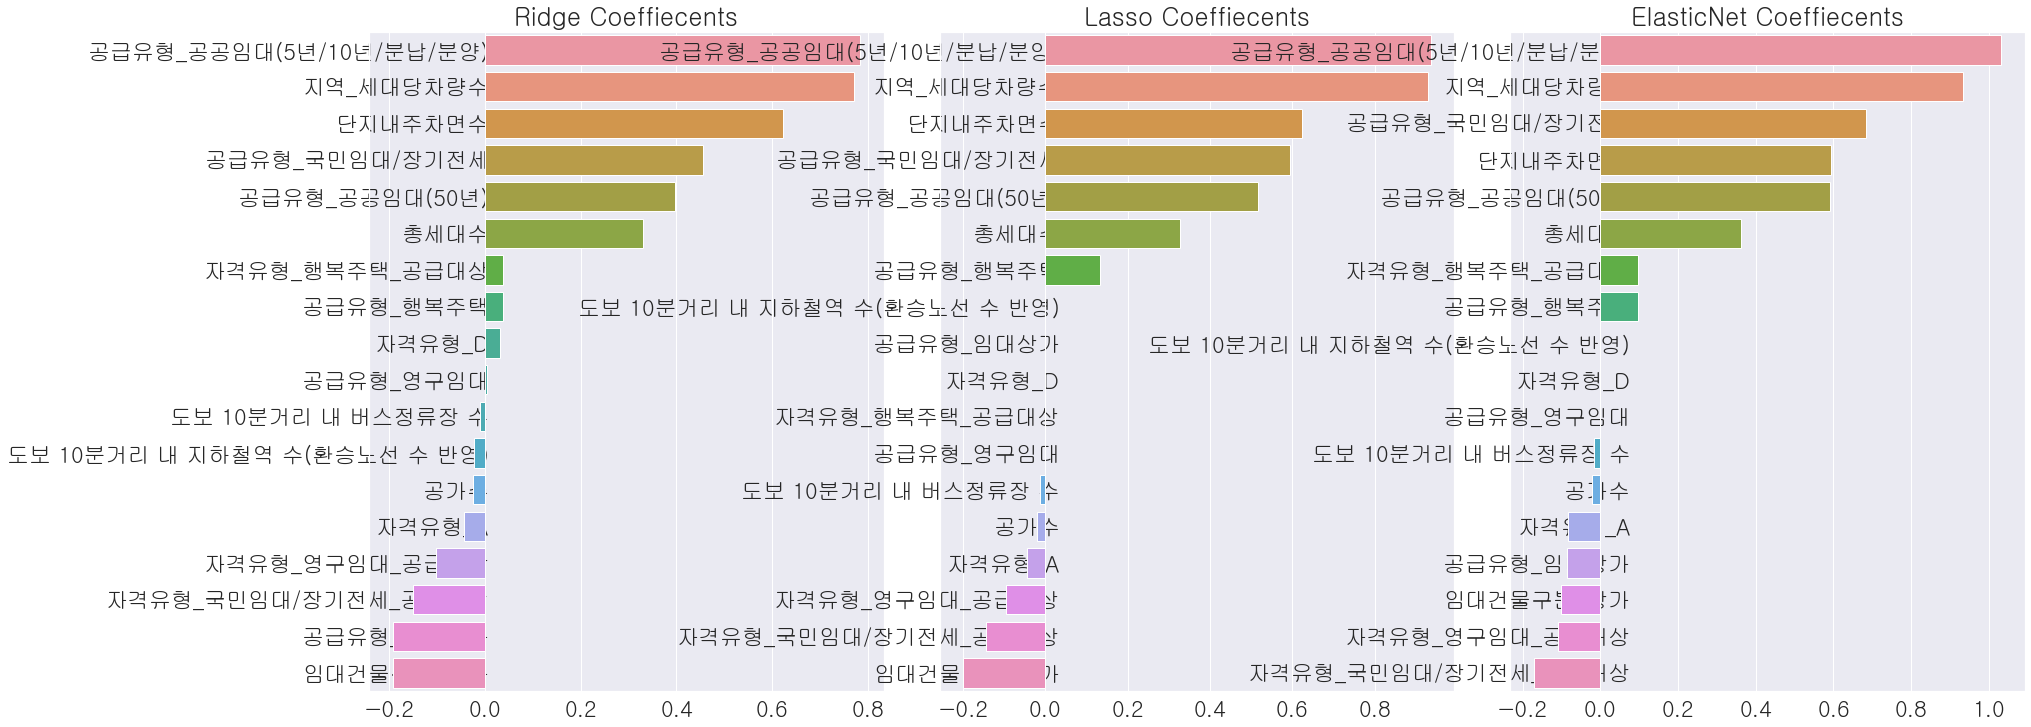

In [140]:
models = [ridge_reg, lasso_reg , elastic_reg]
visualize_coefficient(models)

In [96]:
# pred = lasso_reg.predict(X_test)
# y_pred = np.expm1(pred)
# X_test['num'] = y_pred
# X_test

In [50]:

submission = pd.DataFrame(data=X_test['num'], index=X_test.index)
submission.reset_index(inplace=True)
submission.columns=['code','num']
submission.to_csv('test.csv',index=False)

KeyError: 'num'

In [51]:
a = X_train.corr()
a[a > 0.5].fillna(0).round(2)

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,임대건물구분_상가
총세대수,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
공가수,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
도보 10분거리 내 버스정류장 수,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
단지내주차면수,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.60,0.00,0.00,0.0,0.62,0.00,0.0,0.00,0.0,0.0,0.00
공급유형_공공임대(50년),0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
공급유형_공공임대(5년/10년/분납/분양),0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
공급유형_국민임대/장기전세,0.0,0.0,0.0,0.0,0.60,0.0,0.0,1.00,0.00,0.00,0.0,0.78,0.00,0.0,0.00,0.0,0.0,0.00
공급유형_영구임대,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,1.00,0.94,0.0,0.00,0.94,0.0,1.00,0.0,0.0,0.94
공급유형_임대상가,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.94,1.00,0.0,0.00,1.00,0.0,0.95,0.0,0.0,1.00


In [146]:
total_data = X_train

In [147]:
total_data.head(1)

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수
단지코드,,,,,,,,,,,,,,,,,,,
C2515,6.302619,2.890372,0.0,1.386294,6.437752,205.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.531508


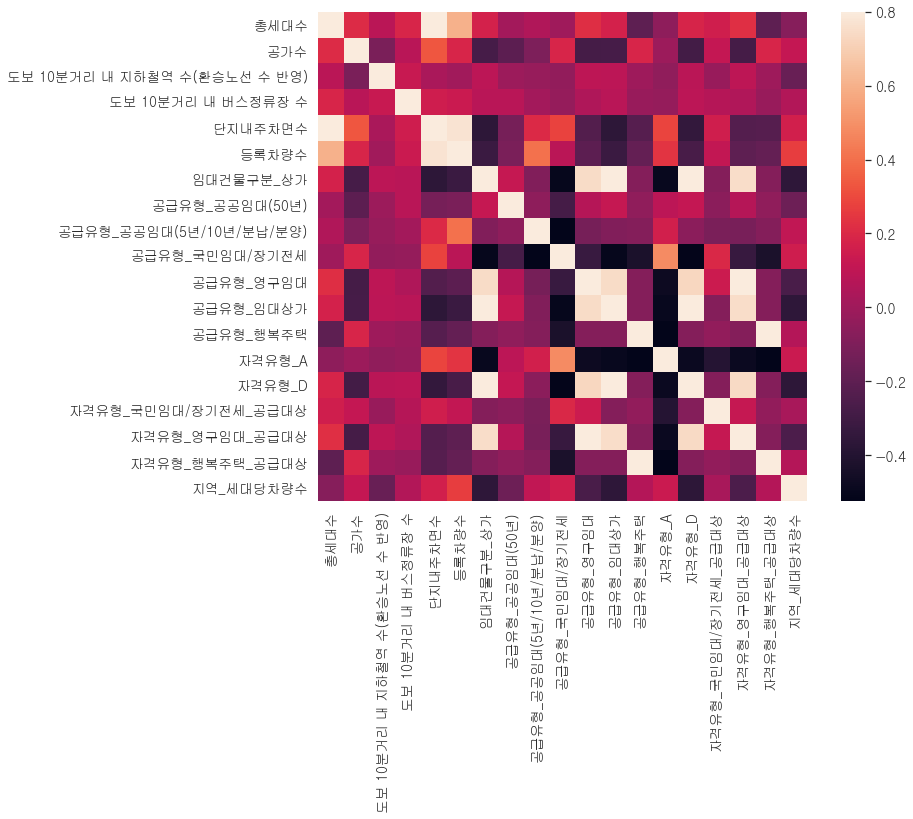

In [148]:
#correlation matrix
corrmat = total_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Index(['등록차량수', '단지내주차면수', '총세대수', '공급유형_공공임대(5년/10년/분납/분양)', '지역_세대당차량수'], dtype='object')


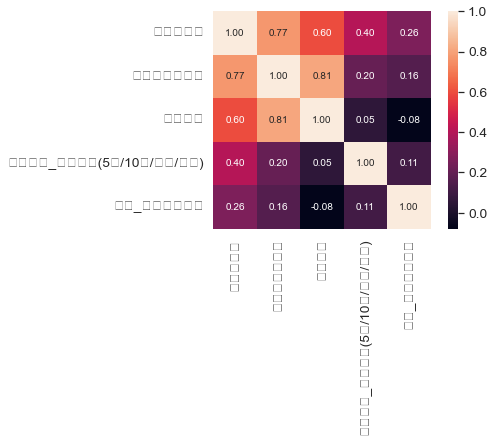

In [154]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap

cols = corrmat.nlargest(k, '등록차량수')['등록차량수'].index
print(cols)
cm = np.corrcoef(total_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [512]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

In [538]:
# ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 10)
# ridge_train.shape

In [591]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]
#         print(train_index)
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        print(train_fold_pred)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean    
    
    

In [656]:
X_tr, X_te, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156)
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_tr.values
X_test_n = X_te.values
y_train_n = y_train.values

In [657]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 10)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 10)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 10)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 10)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 


In [658]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피터 데이터 세트를 결합해서 최종데이터세트 생성
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [659]:
Stack_final_X_train.shape

(325, 4)

In [660]:
# 최종 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.001)

In [661]:
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mae = mean_absolute_error(np.expm1(y_test),np.expm1(final))


print('스태킹 회귀 모델의 최종 RMSE 값은:', mae)

스태킹 회귀 모델의 최종 RMSE 값은: 110.53926306389542


In [664]:
ridge_pre = ridge_reg.predict(X_test).reshape(-1,1)
lasso_pre = lasso_reg.predict(X_test).reshape(-1,1)
xgb_pre = xgb_reg.predict(X_test).reshape(-1,1)
lgbm_pre = lgbm_reg.predict(X_test).reshape(-1,1)

In [665]:
Stack_pre = np.concatenate((ridge_pre, lasso_pre, 
                                      xgb_pre, lgbm_pre), axis=1)

In [667]:
Stack_pre.shape

(150, 4)

In [672]:
final_pred = np.expm1(meta_model_lasso.predict(Stack_pre))

In [673]:
X_test['num'] = final_pred

In [675]:
X_test.head()

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,num
단지코드,,,,,,,,,,,,,,,,,,,
C1072,6.626718,2.708050,0.0,1.098612,6.527958,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.629381,573.110465
C1128,7.211557,2.302585,0.0,1.386294,7.104144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.629381,966.482071
C1456,6.429719,2.944439,0.0,2.833213,6.306275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.343049,428.564613
C1840,6.386879,2.079442,0.0,1.386294,6.298949,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822,510.904731
C1332,7.168580,2.484907,0.0,1.098612,7.014814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.629381,947.236350


In [676]:
submission = pd.DataFrame(data=X_test['num'], index=X_test.index)
submission.reset_index(inplace=True)
submission.columns=['code','num']
submission.to_csv('submission_0929_2.csv',index=False)

In [617]:
# # 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
# ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 10)
# lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 10)
# xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 10)  
# lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 10)

### 대환님 -> 성별 적용하기
### 지훈님 -> 오버샘플링 적용하기
### 이상치 확인

- 예측값 혼합

In [1072]:
# # 개별 모델 예측값 혼합으로 최종 예측값 도출
# # 개별 모델 학습
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# 개별모델 예측
ridge_pred = ridge_reg.predict(X_te)
lasso_pred = lasso_reg.predict(X_te)
pred = 0.4 * ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
y_pred = np.expm1(pred)
y_te = np.expm1(y_te)
mae  = mean_absolute_error(y_te, y_pred)
# len(ridge_pred), len(lasso_pred), len(p)
mae

105.79730688628685

In [1039]:
ridge_reg.fit(X,y)
ridge_pred = ridge_reg.predict(X_test)
final_pred = np.expm1(ridge_pred)
X_test['num'] = final_pred

In [1000]:
X_test.drop('num',axis=1,inplace=True)

In [1040]:
X_test

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_세대당차량수,num
단지코드,,,,,,,,,,,,,,,,,,,
C1072,6.626718,2.708050,0.0,1.098612,6.527958,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423,160.990906
C1128,7.211557,2.302585,0.0,1.386294,7.104144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.633423,291.323586
C1456,6.429719,2.944439,0.0,2.833213,6.306275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.343049,190.888405
C1840,6.386879,2.079442,0.0,1.386294,6.298949,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.607822,170.957744
C1332,7.168580,2.484907,0.0,1.098612,7.014814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.633423,235.775367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2456,5.857933,2.890372,0.0,1.609438,5.602119,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.544082,65.048028
C1266,6.391917,3.583519,0.0,0.693147,6.386879,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.622633,110.954462
C2152,4.795791,2.302585,0.0,0.693147,3.713572,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.582275,20.792729


In [916]:
submission = pd.DataFrame(data=X_test['num'], index=X_test.index)
submission.reset_index(inplace=True)
submission.columns=['code','num']
submission.to_csv('submission_0930_over.csv',index=False)

**agg 풀고 다시 해보기**

(407, 4)

In [ ]:
submission = pd.DataFrame(data=X_test['num'], index=X_test.index)
submission.reset_index(inplace=True)
submission.columns=['code','num']
submission.to_csv('test.csv',index=False)